In [18]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import cv2
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds

In [19]:
img_shape = (img_w, img_h, img_c) = (128, 128, 3)

In [20]:
epoch_num = 5
lr = 0.0001
buffer_size = 1000
batch_size = 16

In [21]:
#Data Load
ds_str = 'oxford_iiit_pet'
ds, info = tfds.load(name=ds_str, with_info=True)

In [22]:
#Pre-processing

def preprocessing_img(ds):
  #img size 변경
  img = tf.image.resize(ds['image'], (img_w, img_h))
  #float 변경 / 0-1 사이로 정규화
  img = tf.cast(img, tf.float32) / 255.0

  #mask size 변경
  mask = tf.image.resize(ds['segmentation_mask'], (img_w, img_h))
  #int 변경
  mask = tf.cast(mask, tf.int32)
  mask = mask - 1

  return img, mask

In [23]:
train_ds = ds['train'].map(preprocessing_img).shuffle(buffer_size).batch(batch_size).prefetch(2)
test_ds = ds['test'].map(preprocessing_img).shuffle(buffer_size).batch(batch_size).prefetch(2)

In [24]:
imgs, masks = next(iter(train_ds))

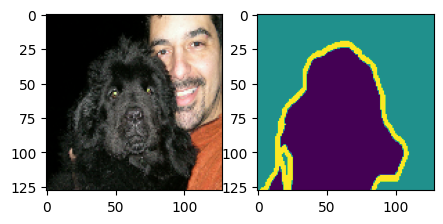

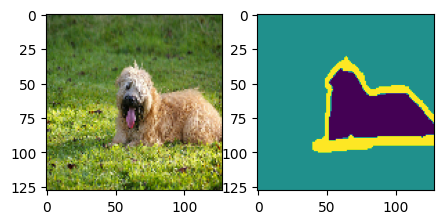

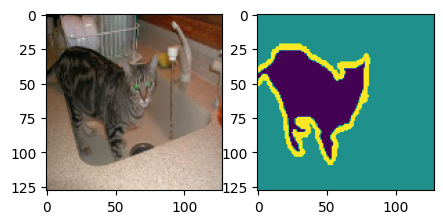

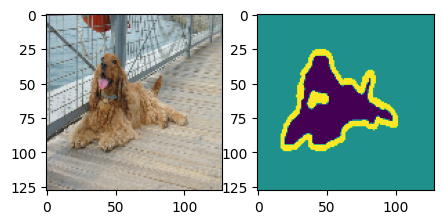

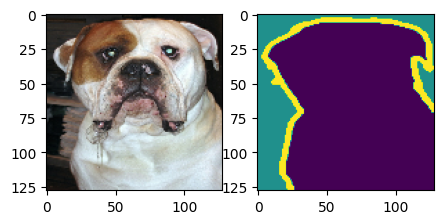

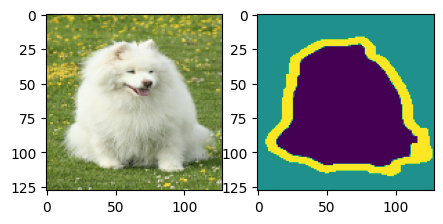

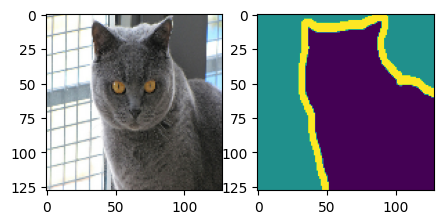

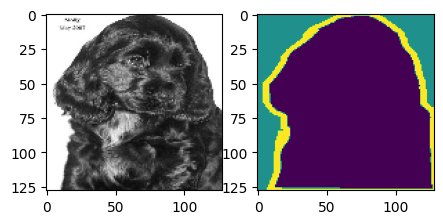

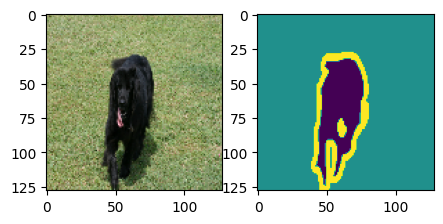

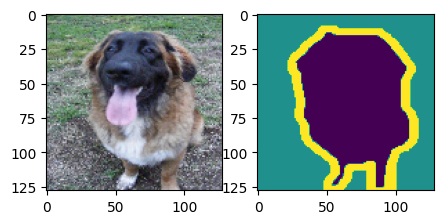

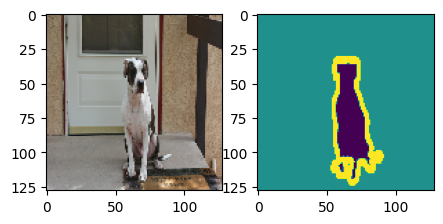

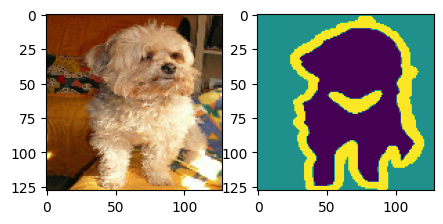

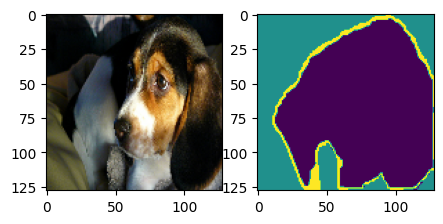

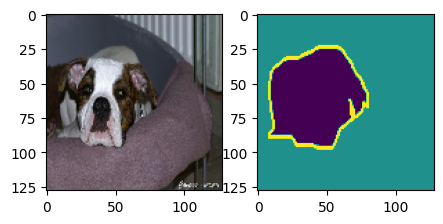

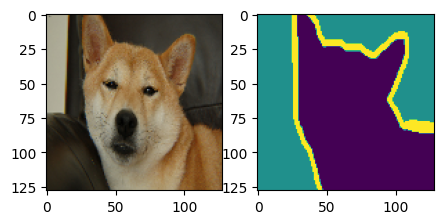

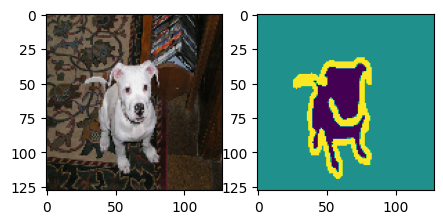

In [25]:
import matplotlib.pyplot as plt

for img, mask in zip(imgs, masks):
  fig = plt.figure(figsize=(5,3))
  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(img.cpu())

  ax2 = fig.add_subplot(1,2,2)
  ax2.imshow(mask)
  plt.show()

In [26]:
#Unet Encoder Backbone 모델 load
#Encoder : 원본 이미지에서 같은 범주에 속하는 픽셀을 결합하면서 이미지를 더작은 크기로 축소 ; 마스크 정답을 활용하여 각 픽셀의 마스크 범주를 0,1,2중 하나로 분류하는 역할
#최종 레이어는 제외한 채로 불러온다
base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top=False)

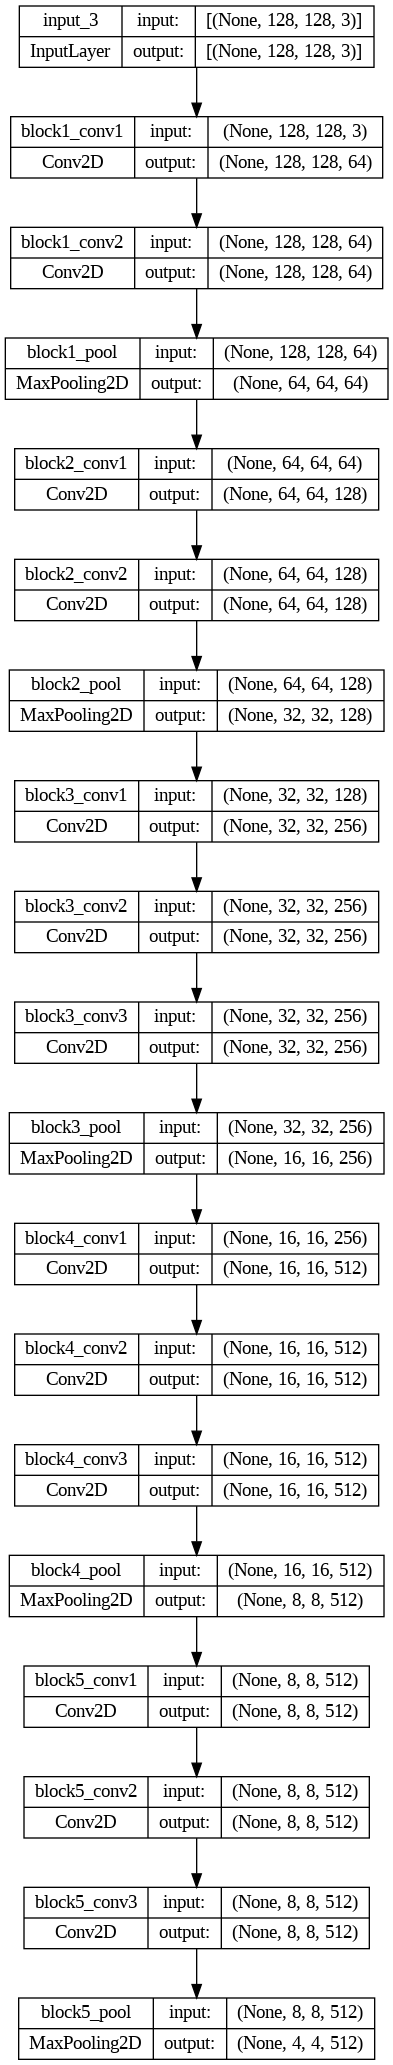

In [27]:
#model layer
tf.keras.utils.plot_model(base_model, show_shapes=True)

In [28]:
#base model - select layer
f_model = tf.keras.Model(inputs=[base_model.input],
                         outputs=[
                             base_model.get_layer(name='block5_conv3').output,  #(?,8,8,512)
                             base_model.get_layer(name='block4_conv3').output,  #(?,16,16,512)
                             base_model.get_layer(name='block3_conv3').output,  #(?,32,32,256)
                             base_model.get_layer(name='block2_conv2').output,  #(?,64,64,128)
                             base_model.get_layer(name='block1_conv2').output   #(?,128,128,64)
                         ])

In [29]:
#파라미터 고정
#사전에 학습된 파라미터를 인코더에 그대로 사용하기 위함
f_model.trainable=False

In [30]:
from tensorflow.keras.layers import Conv2DTranspose, Add, Dense, Conv2D
#Unet 구조의 모델 정의

i = tf.keras.Input(shape=img_shape)

out_8_8_512, out_16_16_512, out_32_32_256, out_64_64_128, out_128_128_64 = f_model(i)

out = Conv2DTranspose(512, 3, strides=2, padding='same')(out_8_8_512)
out = Add()([out, out_16_16_512])

out = Conv2DTranspose(256, 3, strides=2, padding='same')(out)
out = Add()([out, out_32_32_256])

out = Conv2DTranspose(128, 3, strides=2, padding='same')(out)
out = Add()([out, out_64_64_128])

out = Conv2DTranspose(64, 3, strides=2, padding='same')(out)
out = Add()([out, out_128_128_64])

out = Conv2D(3, 3, activation='relu', padding='same')(out)
out = Dense(3,activation='softmax' )(out) #0,1,2

unet_model = tf.keras.Model(inputs=[i], outputs=[out])

In [31]:
unet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model_2 (Functional)        [(None, 8, 8, 512),          1471468   ['input_4[0][0]']             
                              (None, 16, 16, 512),        8                                       
                              (None, 32, 32, 256),                                                
                              (None, 64, 64, 128),                                                
                              (None, 128, 128, 64)]                                               
                                                                                            

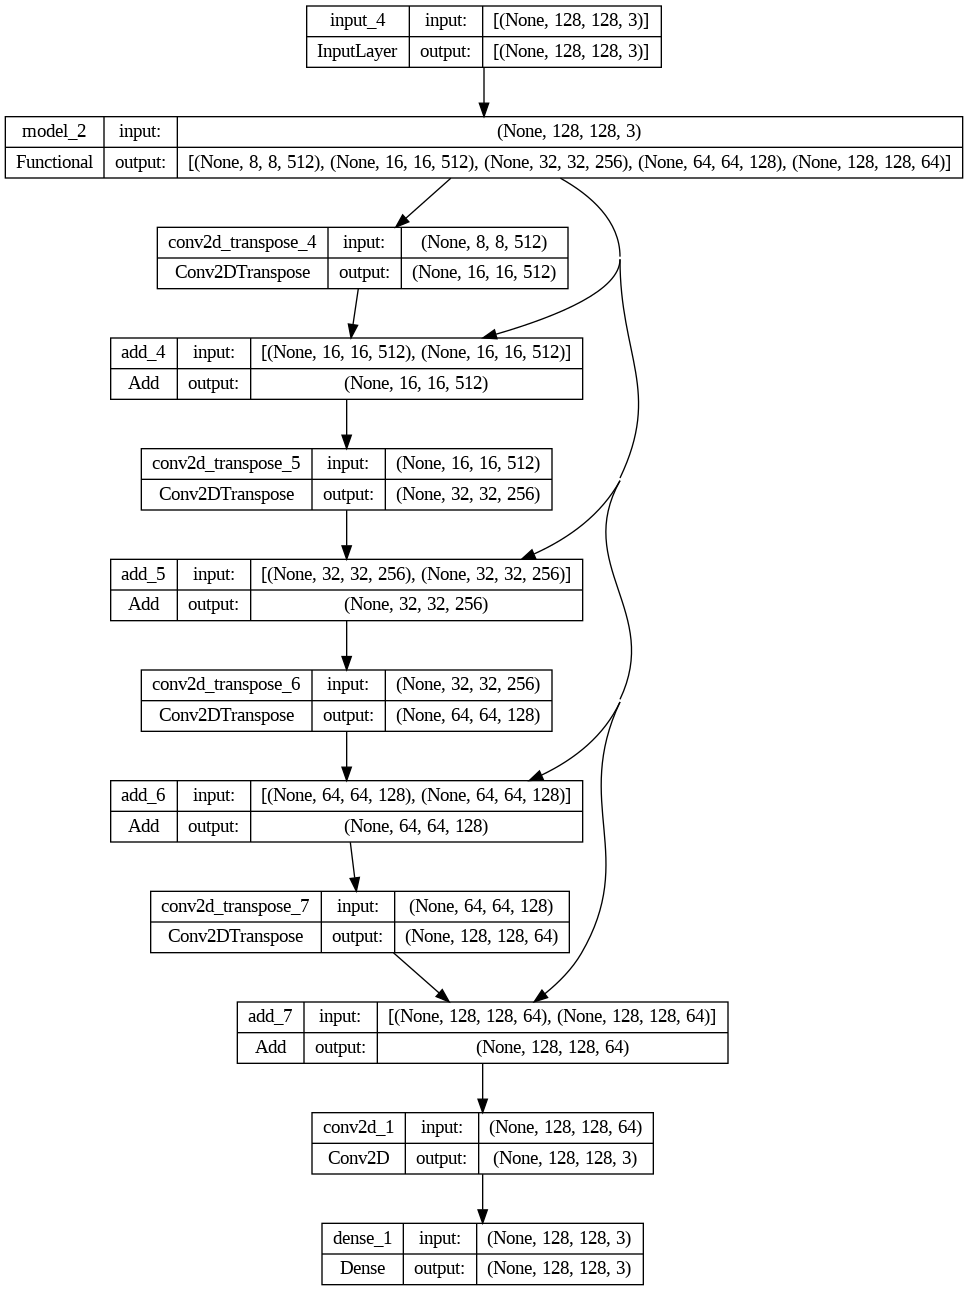

In [32]:
tf.keras.utils.plot_model(unet_model, show_shapes=True)

In [33]:
#Model Compile
loss_f = tf.losses.SparseCategoricalCrossentropy()
opt = tf.optimizers.Adam(lr)

unet_model.compile(optimizer=opt, loss=loss_f, metrics=['accuracy'])

In [34]:
#Model Fit
unet_model.fit(train_ds, batch_size=batch_size, epochs=epoch_num)

Epoch 1/5
230/230 [==============================] - 28s 77ms/step - loss: 0.9118 - accuracy: 0.6791
Epoch 2/5
230/230 [==============================] - 20s 79ms/step - loss: 0.5132 - accuracy: 0.7977
Epoch 3/5
230/230 [==============================] - 21s 79ms/step - loss: 0.4639 - accuracy: 0.8107
Epoch 4/5
230/230 [==============================] - 21s 80ms/step - loss: 0.4387 - accuracy: 0.8206
Epoch 5/5
230/230 [==============================] - 21s 79ms/step - loss: 0.4205 - accuracy: 0.8364


In [38]:
#Inference

#1개 배치 선택
img, mask = next(iter(test_ds))

#Predict
pred = unet_model.predict(img)

1/1 [==============================] - 0s 89ms/step


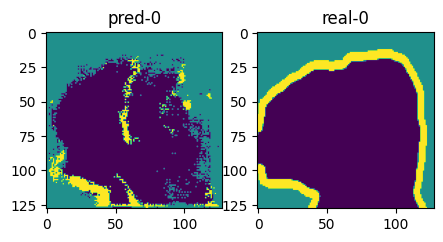

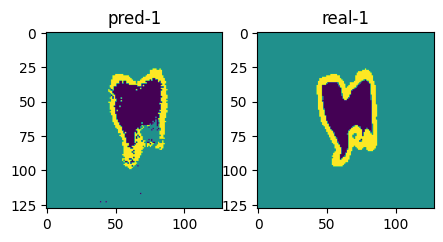

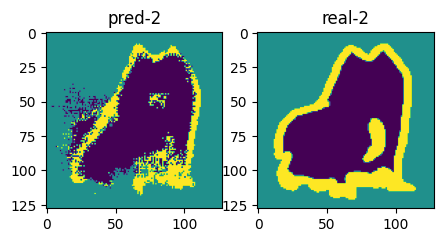

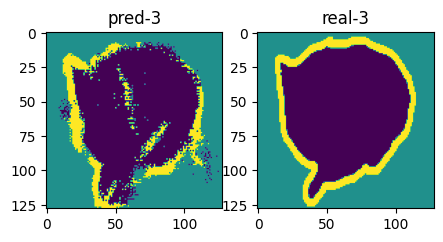

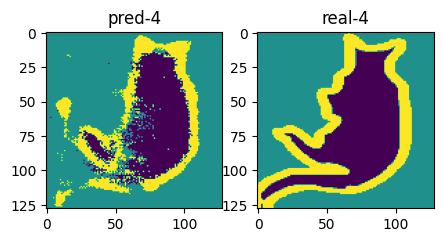

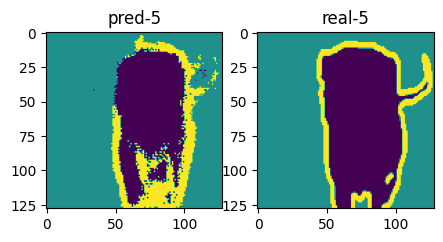

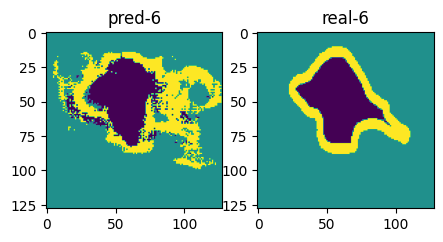

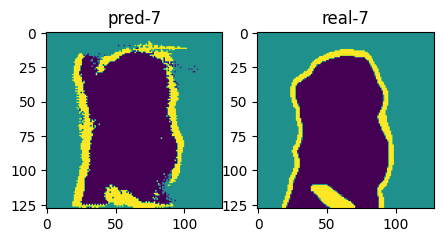

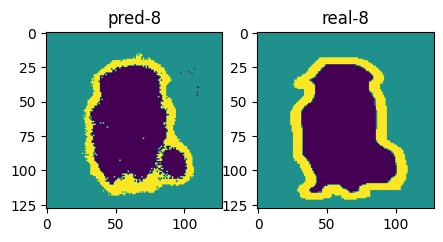

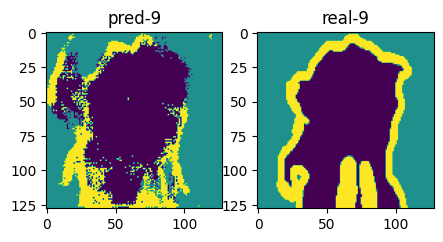

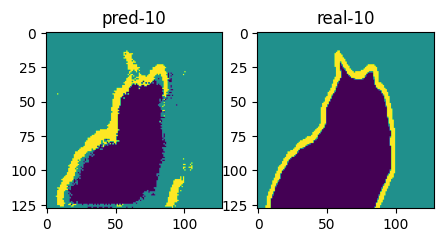

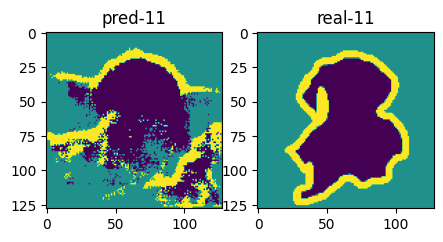

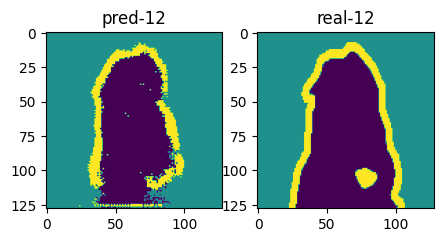

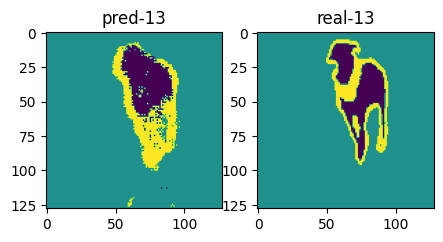

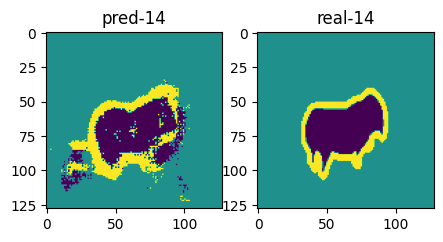

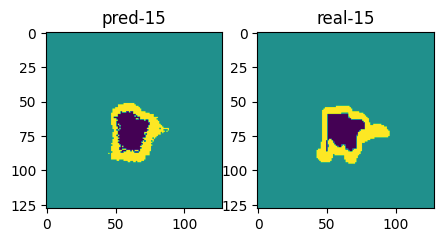

In [40]:
import matplotlib.pyplot as plt

for i in range(len(mask)):
  pred_mask = np.argmax(pred[i], -1)
  real_mask = mask[i]

  fig = plt.figure(figsize=(5,3))

  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(pred_mask)
  ax1.set_title(f'pred-{i}')

  ax2 = fig.add_subplot(1,2,2)
  ax2.imshow(real_mask)
  ax2.set_title(f'real-{i}')

  plt.show()